In [1]:
!nvidia-smi

Thu Nov 30 19:42:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/My Drive')
!pwd

/content/drive/My Drive


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import random_split
torch.cuda.empty_cache()

%matplotlib inline
%load_ext autoreload
%autoreload 2

# LOADING THE TRAINING SET

In [5]:
# load the data

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.image as mpimg

class SatelliteDataset(Dataset):
    def __init__(self, images_dir, ground_truth_dir, transform=None):
        self.images_dir = images_dir
        self.ground_truth_dir = ground_truth_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.images[idx])
        image = mpimg.imread(img_name)


        ground_truth_name = os.path.join(self.ground_truth_dir, self.images[idx])
        ground_truth = mpimg.imread(ground_truth_name)

        if self.transform:
            image = self.transform(image)
            ground_truth = self.transform(ground_truth)

        return image, ground_truth




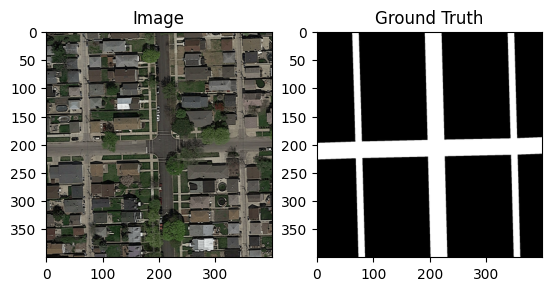

In [6]:
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = SatelliteDataset("training/images", "training/groundtruth", transform=transform)

plt.subplot(1, 2, 1)

plt.imshow(dataset[0][0].permute(1, 2, 0))
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(dataset[0][1].squeeze(), cmap='gray')

plt.title('Ground Truth')

plt.show()



# defining the model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Risidual Dilated Convolution block
class ResidualDilatedBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.rdb = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, dilation=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2)
        )
        self.convID = nn.Conv2d(in_channels, out_channels, kernel_size=1,stride= 2, padding=0)
    def forward(self, x):
        return self.rdb(x)+ self.convID(x)

#Risidual block
class RisidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.rdb = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2)
        )
        self.convID = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    def forward(self, x):
        return self.rdb(x)+ self.convID(x)

#Double Convolution block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        self.convID = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        return self.double_conv(x)+self.convID(x)

# Upsampling block
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()

        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2), #32x32 -> 64x64
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
    def forward(self, x, input):
        x = self.upconv(x)
        x = torch.cat([x, input], dim=1)
        return x

class PPM(nn.Module):
    """
        Pyramid Pooling Module (PPM) class
    """
    def __init__(self, num_class, fc_dim, pool_scales=(1, 2, 3, 6)):
        super(PPM, self).__init__()

        self.ppm = []
        for scale in pool_scales:
            self.ppm.append(nn.Sequential(nn.AdaptiveAvgPool2d(scale),
                                          nn.Conv2d(fc_dim, 512, kernel_size=1, bias=False),
                                          nn.BatchNorm2d(512),
                                          nn.ReLU(inplace=True)))

        self.ppm = nn.ModuleList(self.ppm)

        self.conv_last = nn.Sequential(
            nn.Conv2d(fc_dim + len(pool_scales)*512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(512, num_class, kernel_size=1)
        )

    def forward(self, x, seg_size=None):
        """
            Forward pass of the PPM architecture
        """
        input_size = x.size()
        ppm_out = [x]

        for pool_scale in self.ppm:
            ppm_out.append(nn.functional.interpolate(pool_scale(x),
                                                     (input_size[2], input_size[3]),
                                                     mode='bilinear',
                                                     align_corners=False))
        ppm_out = torch.cat(ppm_out, 1)

        x = self.conv_last(ppm_out)

        if seg_size:  # is True during inference
            x = nn.functional.interpolate(x, size=seg_size, mode='bilinear', align_corners=False)
            x = nn.functional.softmax(x, dim=1)
        else:
            x = nn.functional.log_softmax(x, dim=1)

        return x



# GC-DCNN model
class GCDCNN(nn.Module):
    def __init__ (self, n_channels, n_classes):
        super(GCDCNN, self).__init__()

        # Encoder
        self.dc1 = DoubleConv(n_channels, 64)
        self.rdb1 = ResidualDilatedBlock(64, 128)
        self.rdb2 = ResidualDilatedBlock(128, 256)
        self.rdb3 = ResidualDilatedBlock(256, 512)

        # PPM
        self.ppm = PPM(1024, 512)

        # Decoder
        # self.up1 = UpConv(1024, 512)
        # self.rb1 = RisidualBlock(512, 256)
        # self.up2 = UpConv(256, 128)
        # self.rb2 = RisidualBlock(256, 128)
        # self.up3 = UpConv(128, 64)
        # self.rb3 = RisidualBlock(128, 64)
        self.up1 = UpConv(1024, 256)
        self.rb1 = RisidualBlock(512, 256)
        self.up2 = UpConv(256, 128)
        self.rb2 = RisidualBlock(256, 128)
        self.up3 = UpConv(128, 64)
        self.rb3 = RisidualBlock(128, 64)

        # Output
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.dc1(x)
        x2 = self.rdb1(x1)
        x3 = self.rdb2(x2)
        x4 = self.rdb3(x3)

        x5 = self.ppm(x4)

        x = self.up1(x5, x3)
        x = self.rb1(x)
        x = self.up2(x, x2)
        x = self.rb2(x)
        x = self.up3(x, x1)
        x = self.rb3(x)

        logits = self.outc(x)
        return logits


# defining the loss function

In [14]:
class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Flatten label and prediction tensors
        inputs = torch.sigmoid(inputs).view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_coeff = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice_coeff

soft_dice_loss = SoftDiceLoss()

def calc_loss(pred, target):
    return  soft_dice_loss(pred, target)

# Training the model

In [18]:
from torch.utils.data import random_split
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score
import copy
import time


def train_model(model, optimizer, scheduler, num_epochs=10):
    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Training phase
        model.train()
        train_loss = 0.0
        train_samples = 0

        # Add variables to store all labels and predictions for F1 calculation
        val_labels_all, val_preds_all = [], []

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                torch.autograd.set_detect_anomaly(True)
                outputs = model(inputs)
                loss = calc_loss(outputs, labels)
                loss.backward()
                optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_samples += inputs.size(0)

        train_epoch_loss = train_loss / train_samples
        print("Training Loss: {:.4f}".format(train_epoch_loss))

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_samples = 0

        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels >0.5
            labels = labels.float()

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = calc_loss(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_samples += inputs.size(0)

            # Store predictions and labels
            preds = (outputs > 0.5).view(-1).cpu().numpy()  # Flatten and threshold predictions
            labels_flat = labels.view(-1).cpu().numpy()  # Flatten labels
            val_labels_all.extend(labels_flat)
            val_preds_all.extend(preds)

        val_epoch_loss = val_loss / val_samples
        print("Validation Loss: {:.4f}".format(val_epoch_loss))

        # Calculate F1 score
        val_f1_score = f1_score(val_labels_all, val_preds_all,average='binary')
        print("Validation F1 Score: {:.4f}".format(val_f1_score))
        scheduler.step()

        # Check if this is the best model so far based on F1 score
        if val_f1_score > best_f1:
            best_f1 = val_f1_score
            best_model_wts = copy.deepcopy(model.state_dict())
            print("New best model saved with F1 Score: {:.4f}".format(best_f1))

        # Print time elapsed for this epoch
        time_elapsed = time.time() - since
        print('Epoch complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# Define device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Splitting dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for train and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

model = GCDCNN(n_channels=3, n_classes=1 ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
# Train the model
trained_model = train_model(model, optimizer, scheduler, num_epochs=100)

Epoch 0/69
----------
Training Loss: 0.5863
Validation Loss: 0.6428
Validation F1 Score: 0.3616
New best model saved with F1 Score: 0.3616
Epoch complete in 0m 47s
Epoch 1/69
----------
Training Loss: 0.4674
Validation Loss: 0.4002
Validation F1 Score: 0.6199
New best model saved with F1 Score: 0.6199
Epoch complete in 0m 47s
Epoch 2/69
----------
Training Loss: 0.4092
Validation Loss: 0.3325
Validation F1 Score: 0.6815
New best model saved with F1 Score: 0.6815
Epoch complete in 0m 47s
Epoch 3/69
----------
Training Loss: 0.3789
Validation Loss: 0.3126
Validation F1 Score: 0.6955
New best model saved with F1 Score: 0.6955
Epoch complete in 0m 47s
Epoch 4/69
----------
Training Loss: 0.3607
Validation Loss: 0.3020
Validation F1 Score: 0.7059
New best model saved with F1 Score: 0.7059
Epoch complete in 0m 47s
Epoch 5/69
----------
Training Loss: 0.3230
Validation Loss: 0.2609
Validation F1 Score: 0.7429
New best model saved with F1 Score: 0.7429
Epoch complete in 0m 47s
Epoch 6/69
-----

# visualize the results

In [24]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Iterate over the validation dataset
for inputs, labels in val_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(inputs)

    # Convert the predicted output to binary values
    predicted = torch.sigmoid(outputs) > 0.5
    #predicted = outputs

    # Convert tensors to numpy arrays
    inputs = inputs.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()

    # Visualize the inputs, ground truth, and predicted masks
    for i in range(inputs.shape[0]):
        plt.subplot(1, 3, 1)
        plt.imshow(inputs[i].transpose(1, 2, 0))
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(labels[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()


AttributeError: ignored

In [22]:
class testDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, f"test_{idx+1}", f"test_{idx+1}.png")
        image = mpimg.imread(img_name)

        if self.transform:
            image = self.transform(image)

        return image


In [23]:
# load the test data
transform = transforms.Compose([
    transforms.ToTensor(),
])
# check if the test_set_masks folder exists, if not create it
if not os.path.exists("test_set_masks"):
    os.makedirs("test_set_masks")
else:
    # delete the contents of the test_set_masks folder
    for file in os.listdir("test_set_masks"):
        os.remove(os.path.join("test_set_masks", file))

# load the test dataset
test_dataset = testDataset("test_set_images", transform=transform)

# run the test data through the model and save the output masks
for i in range(len(test_dataset)):
    image = test_dataset[i].unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
    output = output > 0.5

    output = output.squeeze().cpu().numpy()

    plt.imsave(f"test_set_masks/test_{i+1}_mask.png", output, cmap='gray')

TypeError: ignored